In [41]:
# Importing Libraries 
import numpy as np
import tensorflow as tf
from keras.models import Sequential,Model
from keras import applications
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array
from keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from mtcnn import MTCNN
from PIL import Image
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import load_model
import numpy as np
import time
import cv2
import os
import cvlib as cv
from PIL import Image,ImageOps

In [55]:
image_size = (48,48)
batch_size=32
images_path = r"../data/sentiment_analysis/"
epochs = 200

In [78]:
# cascPath = "/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml"
# eyePath = "/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_eye.xml"
# smilePath = "/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_smile.xml"
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
# smileCascade = cv2.CascadeClassifier(smilePath)

In [43]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    h = image.shape[0]
    w = image.shape[1]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    
    # return the resized image
    return resized

In [108]:
def extract_face(filename, required_size=(48, 48)):
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixels = np.asarray(image)
    face, confidence = cv.detect_face(pixels)
    pixels = np.asarray(gray)
    for idx, f in enumerate(face):
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        face_crop = np.copy(pixels[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        w,h = face_crop.shape[1],face_crop.shape[0]
        new_image = np.zeros((48,48,1))
        if w>h:
            image = image_resize(face_crop,width=48)
        elif h>w:
            image = image_resize(face_crop,height=48)
        else:
            image = image_resize(face_crop,width=48,height=48)
        image = np.expand_dims(image,axis=2)
        new_image[:image.shape[0], :image.shape[1]] = image
        return new_image

In [45]:
datagen=ImageDataGenerator(rescale=1./255,shear_range=0.3,zoom_range=0.5)
train_generator=datagen.flow_from_directory(directory=images_path+"/train/",class_mode="categorical", target_size=image_size, batch_size=batch_size,shuffle=True,seed=42,color_mode="grayscale")
val_generator=datagen.flow_from_directory(directory=images_path+"/validation/",class_mode="categorical", target_size=image_size, batch_size=batch_size,shuffle=True,seed=42,color_mode="grayscale")

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Creating a test Image

In [121]:
thin_guy_location = r"C:\Users\yomaa\OneDrive\Pictures\bmi_500.jpg"

#preprocess the image
thin_guy = extract_face(thin_guy_location)
# thin_guy = thin_guy/255
# thin_guy = np.expand_dims(thin_guy, axis=0)
# thin_guy.shape

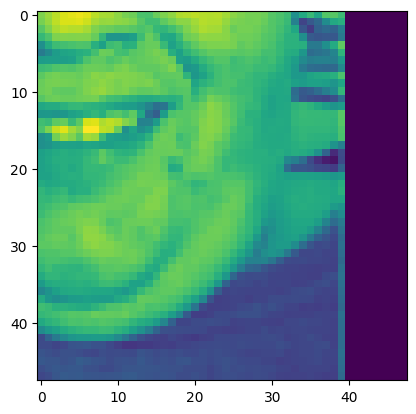

In [122]:
plt.imshow(thin_guy)

In [54]:
def create_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(kernel_size=(3,3), filters=128, activation='relu', input_shape=image_size + (1,))) # 198,198,32
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=128,kernel_size = (3,3),activation='relu')) 
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=512,kernel_size = (3,3),activation='relu'))
    model.add(Conv2D(filters=512,kernel_size = (3,3),activation='relu'))
    model.add(AveragePooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=64,activation='relu'))
    model.add(Dense(units=7,activation='softmax'))
    model.compile(
                loss='categorical_crossentropy', 
                metrics=['accuracy',tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")],
                optimizer='adam'
                )
    return model
classifier = create_model()
classifier.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 23, 23, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 128)       147584    
                                                                 
 conv2d_44 (Conv2D)          (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 9, 128)       

In [56]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('sentiment_standard.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
output = classifier.fit(train_generator,validation_data=val_generator,epochs=epochs,callbacks=[model_checkpoint])

Epoch 1/200
900/901 [============================>.] - ETA: 0s - loss: 1.8244 - accuracy: 0.2479 - recall: 0.0080 - categorical_accuracy: 0.2479
Epoch 1: val_accuracy improved from -inf to 0.25219, saving model to sentiment_standard.h5
901/901 [==============================] - 29s 32ms/step - loss: 1.8242 - accuracy: 0.2479 - recall: 0.0080 - categorical_accuracy: 0.2479 - val_loss: 1.8871 - val_accuracy: 0.2522 - val_recall: 0.0477 - val_categorical_accuracy: 0.2522
Epoch 2/200
899/901 [============================>.] - ETA: 0s - loss: 1.7033 - accuracy: 0.3175 - recall: 0.0522 - categorical_accuracy: 0.3175
Epoch 2: val_accuracy did not improve from 0.25219
901/901 [==============================] - 15s 17ms/step - loss: 1.7032 - accuracy: 0.3177 - recall: 0.0523 - categorical_accuracy: 0.3177 - val_loss: 1.8697 - val_accuracy: 0.2230 - val_recall: 0.0303 - val_categorical_accuracy: 0.2230
Epoch 3/200
900/901 [============================>.] - ETA: 0s - loss: 1.5841 - accuracy: 0.37

In [115]:
class_map = train_generator.class_indices
class_map = {v: k for k, v in class_map.items()}

In [123]:
class_map

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [116]:
classifier = tf.keras.models.load_model("sentiment_standard.h5")
predicted = classifier.predict(thin_guy)
# predicted = np.where(predicted == 1)
print(class_map[predicted[0].argmax()],max(predicted[0]))

1/1 [==============================] - 0s 70ms/step
sad 0.9973935


In [14]:
train_generator.class_indices.keys()

dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

Continue Training

In [29]:
classifier.fit(train_generator,validation_data=val_generator,epochs=epochs,callbacks=[model_checkpoint])

Epoch 1/50
901/901 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.7385 - recall: 0.6655 - categorical_accuracy: 0.7385
Epoch 1: val_accuracy improved from 0.58350 to 0.58520, saving model to sentiment_standard.h5
901/901 [==============================] - 208s 230ms/step - loss: 0.7049 - accuracy: 0.7385 - recall: 0.6655 - categorical_accuracy: 0.7385 - val_loss: 1.2571 - val_accuracy: 0.5852 - val_recall: 0.5125 - val_categorical_accuracy: 0.5852
Epoch 2/50
901/901 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7447 - recall: 0.6724 - categorical_accuracy: 0.7447
Epoch 2: val_accuracy did not improve from 0.58520
901/901 [==============================] - 190s 210ms/step - loss: 0.6962 - accuracy: 0.7447 - recall: 0.6724 - categorical_accuracy: 0.7447 - val_loss: 1.2534 - val_accuracy: 0.5828 - val_recall: 0.5183 - val_categorical_accuracy: 0.5828
Epoch 3/50
901/901 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 

In [58]:
classifier = tf.keras.models.load_model("sentiment_standard.h5")
predicted = classifier.predict(thin_guy)
# predicted = np.where(predicted == 1)
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print(labels[predicted[0].argmax()],max(predicted[0]))

1/1 [==============================] - 0s 70ms/step
sad 0.998287


In [39]:
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))

In [40]:
vgg_model.save("VGGFace_224.hd5")

INFO:tensorflow:Assets written to: VGGFace_224.hd5\assets


INFO:tensorflow:Assets written to: VGGFace_224.hd5\assets
